```yaml
#%mldev nb_context

pipeline:
  - imports
  - params
  - def_funcs
  - def_funcs_2
  - plot_data
  - x_acc_test_
  - modif
  - modif_2
  - fig_1
  - hankelMatrix
  - Point_zero
  - abn
  - r
  - indexes
  - fig_2
  - indexes_2
  - fig_3
  - fig_4
  - long_walk
  - hankel_long
  - phase_traj_dot
  - point_for_projection
  - projection_point
  - 3dcheck
  - limit
  - D
  - printD
  - indexes_3
  - printIndexes
  - 3dcheck_2
  - fig_5
  - mean
  - std
  - imports_2
  - fig_6
  - imports_3
  - find_peaks
  - print_indexes_init
  - print_temp
  - diff_temp
  - plot_3
  - xpca
  - xsp
  - fig_7
  - xstd
  - fig_8
  - needed
  - diff_needed
  - plotly_white
  - plotly_white_2

```

In [1]:
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
import warnings
import scipy
from sklearn.decomposition import PCA


from visuals import *
from my_lib import *

#%mldev imports

In [2]:
warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

#%mldev params

In [3]:
def CartesianToSpherical(point):
    r = np.sqrt(sum(point ** 2))
    n = len(point)
    phi = np.zeros(n - 1)
    
    for i in range(n - 2):
        phi[i] = np.arccos(point[i] / np.sqrt(sum(point[i:] ** 2)))
        
    if point[-1] >= 0:
        phi[n - 2] = np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
    else:
        phi[n - 2] = 2 * np.pi - np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
        
    return np.hstack((phi, r))


def TrajectoryToSpherical(tr):
    tr_spherical = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_spherical[i] = CartesianToSpherical(point)
    return tr_spherical


def SphericalToCartesian(point):
    phi, r = point[:-1], point[-1]
    n = len(point)
    x = np.zeros(n) 
    cur = r
    
    for i in range(n - 1):
        x[i] = cur * np.cos(phi[i])
        cur *= np.sin(phi[i])

    x[n - 1] = cur
    return x
    

def TrajectoryToCartesian(tr):
    tr_cartesian = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_cartesian[i] = SphericalToCartesian(point)
    return tr_cartesian
#%mldev def_funcs

In [4]:
def orientation(point, n, point0, dist=False):
    ans = 0
    for i in range(len(n)):
        ans += n[i]*(point[i] - point0[i])
    if dist:
        return ans/(np.sum(n**2))**.5
        
    else:
        return np.sign(ans)

def HankelMatrix(X, L):  
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

def prepare_time_series(_dir, centred = True):
    data = pd.read_csv(_dir, delimiter =';', decimal=',')
    
    frequency = len(data)/(data['time'].values[-1]-data['time'].values[0])
    
    assert 490 < frequency < 510, f'Bad frequency {frequency}'

    _x = ( (data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
    
    if centred:
        _m = np.mean(_x)
        _x = (_x-_m)
        
    _t = (data['time'].values).astype(float).reshape([-1,])

    _t = np.linspace(0,_t[-1]-_t[0],len(_x))
        
    return _x,_t

#%mldev def_funcs_2

# Алгоритм с использованием средней фазовой траетории

In [5]:
x_acc_test, t_test = prepare_time_series('./30 sec 2_accm.csv')

x_acc, t = prepare_time_series('./long_walk_100_acc.csv')

dt = 450*20
x_acc = x_acc[7007:7007+dt]
fig = go.Figure()
fig.add_scatter(y = x_acc, mode='lines', name='x_acc')
fig.show()

#%mldev plot_data

In [6]:
x_acc_test_ = x_acc_test[:25000]*0.8

#%mldev x_acc_test_

In [7]:
modif = np.concatenate([np.ones(3000),
                        np.linspace(1,0,500),
                        np.zeros(1500)+.2,
                        np.linspace(0,1,1000),
                        np.ones(6000),
                        np.linspace(1,0,400),
                        np.zeros(4000)+.2,
                        np.linspace(0,1,1000)],
                        axis = 0)
#%mldev modif

In [8]:
modif = np.concatenate([modif,
                       np.ones(len(x_acc_test_)-len(modif))],
                       axis = 0)
#%mldev modif_2

In [9]:
x_acc_test_m = x_acc_test_ *0.8 * modif
fig = go.Figure()
fig.add_scatter(y = x_acc_test_m, mode='lines', name='x_acc')
fig.show()

#%mldev fig_1

In [10]:
X = HankelMatrix(x_acc,500)
X_test = HankelMatrix(x_acc_test_m,500)

pca = PCA(n_components = 3)
X_PCA = pca.fit_transform(X)
X_PCA_test = pca.transform(X_test)

####################################################
X_mean = X_PCA[:460]
for i in range(1,18):
    X_mean += X_PCA[460*i:460*(i+1)]
X_mean /= 18

####################################################
X_std = (X_PCA[:460] - X_mean)**2
for i in range(1,18):
    X_std += (X_PCA[460*i:460*(i+1)] - X_mean)**2
X_std = (X_std/18)**.5

D = 3*X_std.mean()

#%mldev hankelMatrix

In [11]:
phase_index = 6060-500
Point_zero_phase = X_PCA[phase_index]
Point_half_phase = X_PCA[phase_index + 230]

#%mldev Point_zero

In [12]:
a = X_PCA[phase_index+1]
b = X_PCA[phase_index-1]
n = (b-a)

#%mldev abn

In [13]:
r = np.array([a + 0*(b-a)])

for t_param in np.linspace(-50,50,200):
    
    _r = np.array([a + t_param*(b-a)])
    
    r = np.concatenate([r,_r], axis = 0)

#%mldev r

In [14]:
indexes = []
for i in range(1,len(X_PCA_test)):
    if (np.sum((Point_zero_phase - X_PCA_test[i])**2))**.5 <= D:
        if orientation(X_PCA_test[i-1],n, Point_zero_phase) != orientation(X_PCA_test[i],n, Point_zero_phase):
            indexes.append(i)
indexes = np.array(indexes)

#%mldev indexes

In [15]:
fig = go.Figure()

fig.update_layout( autosize=False, width=950, height=500)

fig.add_scatter(y = x_acc_test_m,x = np.arange(len(x_acc_test_m)), mode='lines', name='X_PCA',opacity=0.5)

indexes_init = indexes + 500
fig.add_scatter(y = x_acc_test_m[indexes_init],
                x = indexes_init, 
                mode='markers',
                marker_size=10)

fig.show()

#%mldev fig_2

### Без ограничения на дисперсию

In [16]:
indexes = []
for i in range(1,len(X_PCA)):
    if (np.sum((Point_zero_phase - X_PCA[i])**2))**.5 <= np.inf:
        if orientation(X_PCA[i-1],n, Point_zero_phase) != orientation(X_PCA[i],n, Point_zero_phase):
            indexes.append(i)
indexes = np.array(indexes)

#%mldev indexes_2

In [17]:
fig = go.Figure()

fig.update_layout( autosize=False, width=950, height=500)

fig.add_scatter(y = x_acc,x = np.arange(len(x_acc)), mode='lines', name='X_PCA',opacity=0.5)

indexes_init = indexes + 500
fig.add_scatter(y = x_acc[indexes_init],
                x = indexes_init, 
                mode='markers',
                marker_size=10)

fig.show()

#%mldev fig_3

In [18]:
if X_PCA.shape[1] ==3:
    p_1, p_2 = np.mgrid[0:np.pi:100j, 0:2*np.pi:100j]

    x_s = Point_zero_phase[0] + D*np.sin(p_1)*np.cos(p_2)
    y_s = Point_zero_phase[1] + D*np.sin(p_1)*np.sin(p_2)
    z_s = Point_zero_phase[2] + D*np.cos(p_1)

    fig_2 = go.Figure()
    fig_2.update_layout(autosize=False, width=1000, height=1000)

    fig_2.add_trace(go.Scatter3d(x=X_PCA[:,0],
                                 y=X_PCA[:,1],
                                 z=X_PCA[:,2],
                                 marker=dict(size=0.1,line=dict(width=0.01)),
                                 name = False
                                )
                    )

    fig_2.add_trace(go.Scatter3d(x=X_mean[:,0],
                                 y=X_mean[:,1],
                                 z=X_mean[:,2],
                                 marker=dict(size=0.1,line=dict(width=0.01)),
                                )
                    )

    fig_2.add_trace(go.Surface(x=x_s,
                               y=y_s,
                               z=z_s,
                               showscale=False,
                               opacity=0.2,
                               surfacecolor = np.linspace(0,100,len(x_s))))

    fig_2.add_trace(go.Scatter3d(x=X_PCA_test[:,0],
                                 y=X_PCA_test[:,1],
                                 z=X_PCA_test[:,2],
                                 marker=dict(size=0.1,line=dict(width=0.01)),
                                )
                    )

    fig_2.add_trace(go.Scatter3d(x=[Point_zero_phase[0]],
                               y=[Point_zero_phase[1]],
                               z=[Point_zero_phase[2]],
                               mode='markers',
                               marker_size=10,
                               marker_color='rgba(10, 250, 250, .7)',
                               name='Zero point'))

    fig_2.add_trace(go.Scatter3d(x=[Point_half_phase[0]],
                               y=[Point_half_phase[1]],
                               z=[Point_half_phase[2]],
                               mode='markers',
                               marker_size=10,
                               marker_color='rgba(10, 250, 250, .7)',
                               name='Half point'))

    fig_2.add_trace(go.Scatter3d(x=r[:,0],
                               y=r[:,1],
                               z=r[:,2],
                               marker=dict(size=0.1,line=dict(width=0.1))))


    fig_2.layout.template = 'plotly_white'
    fig_2.show()

    #%mldev fig_4

Output hidden; open in https://colab.research.google.com to view.

# Алгоритм на чистых данных (модификация Мотренко)

In [19]:
x_acc, t = prepare_time_series('./long_walk_100_acc.csv')
dt = 450*20
x_acc = x_acc[7007:7007+dt]

#%mldev long_walk

In [20]:
X = HankelMatrix(x_acc,500)
fig = go.Figure()
fig.add_scatter(y = x_acc, mode='lines', name='x_acc')
fig.show()

#%mldev hankel_long

In [21]:
#точка на фазовой траектории
index_0 = 6060-500
phi_0 = X_PCA[index_0]

#направляющий вектор прямой из центра в точку фазовой траектории
n_ph = phi_0 - 0

#%mldev phase_traj_dot

In [22]:
#находим направляющий вектор для касательной и точку для проекции на этой прямой
a = X_PCA[index_0+1]
b = X_PCA[index_0-1]
n = (b-a)
point_for_projection = a + n*(-10)

#%mldev point_for_projection

In [23]:
# Находим плоскоть перпендикулярную прямой из центра и проходящуую через point_for_projection
# Получем уравнение вида n_ph[0]*(x[0] - point_for_projection[0]) + ... = 0
# Получем уравнение прямой из центра координат в параметрической (относительно параметра t) виде
#         x[0] = 0 + n_ph[0] * t
# Подставляем в уравнение  плоскости n_ph[0]*(n_ph[0]*t - point_for_projection[0]) + ... = 0
# Находим t 
t = np.sum(n_ph * point_for_projection)/np.sum(n_ph**2)

projection_point = n_ph * t

#%mldev projection_point

In [24]:
# Проверка на 3мерном случае 
if X_PCA.shape[1] ==3:
    fig_2 = go.Figure()
    fig_2.update_layout(autosize=False, width=800, height=800)
    fig_2.add_trace(go.Scatter3d(x=X_PCA[:,0],
                                 y=X_PCA[:,1],
                                 z=X_PCA[:,2],
                                 marker=dict(size=0.1,line=dict(width=0.01)),
                                 name = False))
    fig_2.add_trace(go.Scatter3d(x=[projection_point[0]],
                               y=[projection_point[1]],
                               z=[projection_point[2]],
                               mode='markers',
                               marker_size=10,
                               marker_color='rgba(10, 250, 250, .7)',
                               name='projection_point'))
    fig_2.layout.template = 'plotly_white'
    fig_2.show()

#%mldev 3dcheck

In [25]:
# получем ветор нормальи для итоговой плоскости
n_final = projection_point - point_for_projection
# Предел по расстоянию (ближе чем середина между максимальный расстоянием между 2мя точакми на таректории)
limit = np.sum(np.abs((np.max(X_PCA,axis = 0) - np.min(X_PCA,axis = 0))))/3.5

#%mldev limit

In [26]:
####################################################
X_mean = X_PCA[:460]
for i in range(1,18):
    X_mean += X_PCA[460*i:460*(i+1)]
X_mean /= 18

####################################################
X_std = (X_PCA[:460] - X_mean)**2
for i in range(1,18):
    X_std += (X_PCA[460*i:460*(i+1)] - X_mean)**2
X_std = (X_std/18)**.5

D = 2*X_std.mean()

#%mldev D

In [27]:
print(f"D:{np.round(D,3)}, Limit:{np.round(limit,3)}")

#%mldev printD

D:24.118, Limit:138.485


In [28]:
indexes = []
for i in range(1,len(X_PCA)):
    if np.sum(np.abs(phi_0 - X_PCA[i])) <= np.inf:
        if orientation(X_PCA[i-1],n_final, np.zeros(len(phi_0))) != orientation(X_PCA[i],n_final, np.zeros(len(phi_0))):
            indexes.append(i)
indexes = np.array(indexes[:-2])

#%mldev indexes_3

In [29]:
indexes

#%mldev printIndexes

array([  36,  145,  255,  373,  490,  597,  705,  822,  946, 1055, 1164,
       1282, 1405, 1512, 1622, 1741, 1865, 1977, 2085, 2202, 2326, 2436,
       2545, 2662, 2788, 2897, 3008, 3127, 3249, 3361, 3471, 3589, 3717,
       3828, 3937, 4057, 4180, 4287, 4396, 4514, 4638, 4746, 4856, 4973,
       5096, 5207, 5316, 5436, 5561, 5670, 5780, 5899, 6021, 6130, 6238,
       6357, 6483, 6593, 6703, 6823, 6947, 7057, 7168, 7289, 7412, 7523,
       7632, 7751, 7874, 7981, 8092, 8211])

In [30]:
# Проверка на 3мерном случае 
if X_PCA.shape[1] ==3:
    fig_2 = go.Figure()
    fig_2.update_layout(autosize=False, width=800, height=800)
    fig_2.add_trace(go.Scatter3d(x=X_PCA[:,0],
                                 y=X_PCA[:,1],
                                 z=X_PCA[:,2],
                                 marker=dict(size=0.1,line=dict(width=0.01)),
                                 name = False))
#     fig_2.add_trace(go.Scatter3d(x=[projection_point[0]],
#                                y=[projection_point[1]],
#                                z=[projection_point[2]],
#                                mode='markers',
#                                marker_size=10,
#                                marker_color='rgba(10, 250, 250, .7)',
#                                name='projection_point'))
    fig_2.add_trace(go.Scatter3d(x=X_PCA[indexes,0],
                                 y=X_PCA[indexes,1],
                                 z=X_PCA[indexes,2],
                               mode='markers',
                               marker_size=10,
                               marker_color='rgba(10, 250, 250, .7)',
                               name='Results'))
    fig_2.layout.template = 'plotly_white'
    fig_2.show()

#%mldev 3dcheck_2

In [31]:
fig = go.Figure()

fig.update_layout( autosize=False, width=950, height=500)
fig.add_scatter(y = x_acc,
                x = np.arange(len(x_acc)),
                mode='lines',
                name='X_PCA',
                opacity=0.5)
indexes_init = indexes + 500
fig.add_scatter(y = x_acc[indexes_init],
                x = indexes_init, 
                mode='markers',
                marker_size=10)
fig.show()

#%mldev fig_5

In [32]:
np.mean(np.diff(indexes_init))
#%mldev mean

115.14084507042253

In [33]:
np.std(np.diff(indexes_init))
#%mldev std

6.26030592477488

In [34]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

#%mldev imports_2

In [35]:
acf_x = acf(
        x_acc_test_m,
        nlags=len(x_acc_test_m)-3000,
        alpha=0.5,
)

fig = go.Figure()
fig.add_scatter(x = np.arange(len(acf_x[0])),
                y = acf_x[0], mode='lines', name='ACF')
fig.show()

#%mldev fig_6

In [36]:
from scipy.signal import find_peaks
#%mldev imports_3

In [37]:
scipy.signal.find_peaks(acf_x[0])[0][2:]
#%mldev find_peaks

array([  219,   260,   372,   428,   473,   517,   728,   896,   940,
         975,  1197,  1363,  1409,  1456,  1503,  1670,  1835,  1881,
        1931,  1984,  2142,  2304,  2348,  2394,  2611,  2770,  2818,
        2868,  2923,  2977,  3083,  3240,  3289,  3343,  3397,  3454,
        3557,  3707,  3760,  3813,  3865,  4032,  4179,  4236,  4285,
        4334,  4388,  4498,  4646,  4705,  4755,  4801,  4867,  4923,
        4971,  5013,  5121,  5185,  5229,  5264,  5316,  5365,  5441,
        5572,  5620,  5667,  5703,  5793,  5848,  5890,  5933,  5982,
        6048,  6098,  6154,  6253,  6278,  6333,  6376,  6411,  6520,
        6639,  6680,  6741,  6822,  6863,  6906,  6987,  7081,  7120,
        7302,  7348,  7394,  7457,  7517,  7561,  7604,  7735,  7785,
        7832,  7876,  7929,  8048,  8092,  8140,  8210,  8265,  8315,
        8359,  8401,  8529,  8581,  8630,  8683,  8766,  8804,  8848,
        9014,  9065,  9154,  9205,  9245,  9283,  9327,  9376,  9449,
        9490,  9585,

In [38]:
indexes_init[:-14]
#%mldev print_indexes_init

array([ 536,  645,  755,  873,  990, 1097, 1205, 1322, 1446, 1555, 1664,
       1782, 1905, 2012, 2122, 2241, 2365, 2477, 2585, 2702, 2826, 2936,
       3045, 3162, 3288, 3397, 3508, 3627, 3749, 3861, 3971, 4089, 4217,
       4328, 4437, 4557, 4680, 4787, 4896, 5014, 5138, 5246, 5356, 5473,
       5596, 5707, 5816, 5936, 6061, 6170, 6280, 6399, 6521, 6630, 6738,
       6857, 6983, 7093])

In [39]:
temp = np.array([938-460])

temp = np.concatenate((temp,indexes_init))

temp

#%mldev print_temp

array([ 478,  536,  645,  755,  873,  990, 1097, 1205, 1322, 1446, 1555,
       1664, 1782, 1905, 2012, 2122, 2241, 2365, 2477, 2585, 2702, 2826,
       2936, 3045, 3162, 3288, 3397, 3508, 3627, 3749, 3861, 3971, 4089,
       4217, 4328, 4437, 4557, 4680, 4787, 4896, 5014, 5138, 5246, 5356,
       5473, 5596, 5707, 5816, 5936, 6061, 6170, 6280, 6399, 6521, 6630,
       6738, 6857, 6983, 7093, 7203, 7323, 7447, 7557, 7668, 7789, 7912,
       8023, 8132, 8251, 8374, 8481, 8592, 8711])

In [40]:
np.diff(temp)
#%mldev diff_temp

array([ 58, 109, 110, 118, 117, 107, 108, 117, 124, 109, 109, 118, 123,
       107, 110, 119, 124, 112, 108, 117, 124, 110, 109, 117, 126, 109,
       111, 119, 122, 112, 110, 118, 128, 111, 109, 120, 123, 107, 109,
       118, 124, 108, 110, 117, 123, 111, 109, 120, 125, 109, 110, 119,
       122, 109, 108, 119, 126, 110, 110, 120, 124, 110, 111, 121, 123,
       111, 109, 119, 123, 107, 111, 119])

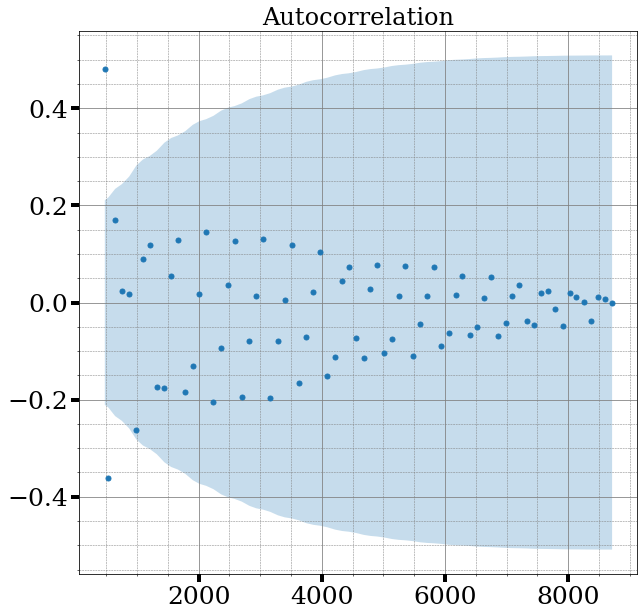

In [41]:
ax = plot_acf(x_acc,
              lags=temp,
              use_vlines = False,
              alpha=0.1
         )
plt.tick_params(axis='both', which='major', labelsize=25,length=8, width=4)
plt.grid(which='major',
    color = 'gray', 
    linewidth = 0.8)
plt.minorticks_on()
plt.grid(which='minor', 
    color = 'gray', 
    linestyle = '--',
    linewidth = 0.5)
plt.show()

#%mldev plot_3

In [42]:
acf_x = acf(
        x_acc,
        nlags=temp,
        alpha=0.5,
)

fig = go.Figure()
fig.add_scatter(x = np.arange(len(acf_x[0])),
                y = acf_x[0], mode='lines', name='ACF')
fig.show()

TypeError: ignored

In [43]:
X = HankelMatrix(x_acc,500)
pca = PCA(n_components = 3)
X_PCA = pca.fit_transform(X)

#%mldev xpca

In [44]:
X_SP = TrajectoryToSpherical(X_PCA)

####################################################
X_meanSP = X_SP[:462]
for i in range(1,18):
    X_meanSP += X_SP[462*i:462*(i+1)]
X_meanSP /= 18

####################################################
X_stdSP = (X_SP[:462] - X_meanSP)**2
for i in range(1,18):
    X_stdSP += (X_SP[462*i:462*(i+1)] - X_meanSP)**2
X_stdSP = (X_stdSP/18)**.5

#%mldev xsp

In [45]:
fig = go.Figure()

fig.update_layout(autosize=False, width=950, height=500)
fig.add_scatter(y = X_meanSP[:,0][219:260],
                mode='lines')
fig.add_scatter(y = X_meanSP[:,1],
                mode='lines')
fig.add_scatter(y = X_meanSP[:,2]/20,
                mode='lines')

# fig.add_scatter(y = X_stdSP[:,1]**2, mode='lines')
fig.show()

#%mldev fig_7

In [46]:
X = HankelMatrix(x_acc,500)
pca = PCA(n_components = 7)
X_PCA = pca.fit_transform(X)

####################################################
X_mean = X_PCA[:460]
for i in range(1,18):
    X_mean += X_PCA[460*i:460*(i+1)]
X_mean /= 18

####################################################
X_std = (X_PCA[:460] - X_mean)**2
for i in range(1,18):
    X_std += (X_PCA[460*i:460*(i+1)] - X_mean)**2
X_std = (X_std/18)**.5

#%mldev xstd

In [47]:
for i in range(X_PCA.shape[1]):
    fig = go.Figure()
    fig.update_layout(autosize=False, width=950, height=500)
    fig.add_scatter(y = X_mean[:,i], mode='lines')
    fig.add_scatter(y = X_mean[:,i] + X_std[:,i], mode='lines')
    fig.add_scatter(y = X_mean[:,i] - X_std[:,i], mode='lines')
    fig.show()

#%mldev fig_8

In [48]:
all_indexes= []
for i in range(len(X_mean)):
    tmp = []
    x_current = X_mean[i]
    for j in range(len(X_mean)):
        if (((X_mean[j,:] + X_std[j,:]) > x_current) & ((X_mean[j,:] - X_std[j,:] < x_current))).all():
            tmp.append(j)
            
    tmp = np.array(tmp)
    all_indexes.append(tmp)


needed = []
for i in range(len(all_indexes)):
    if (np.diff(all_indexes[i]) > 1).any():
        needed.append(i)

#%mldev needed

In [49]:
np.diff(needed)
#%mldev diff_needed

array([  1,   1,   1,   1,   1, 450,   1,   1,   1,   1])

In [50]:
fig_2 = go.Figure()
fig_2.update_layout(autosize=False, width=800, height=800)
fig_2.add_trace(go.Scatter3d(x=X_mean[:,0],
                             y=X_mean[:,1],
                             z=X_mean[:,2],
                             marker=dict(size=0.1,line=dict(width=10)),
                             name = False))
fig_2.add_trace(go.Scatter3d(x=X_PCA[:,0],
                             y=X_PCA[:,1],
                             z=X_PCA[:,2],
                             marker=dict(size=0.1,line=dict(width=0.01)),
                             name = False))
for i in range(0,len(needed),10):
    fig_2.add_trace(go.Scatter3d(x=X_mean[all_indexes[needed[i]],0],
                                 y=X_mean[all_indexes[needed[i]],1],
                                 z=X_mean[all_indexes[needed[i]],2],
                                 mode='markers',
                                 marker_size=10))
    
fig_2.layout.template = 'plotly_white'
fig_2.show()

#%mldev plotly_white

In [51]:
fig_2 = go.Figure()
fig_2.update_layout(autosize=False, width=800, height=800)
fig_2.add_trace(go.Scatter3d(x=X_mean[:,0],
                             y=X_mean[:,1],
                             z=X_mean[:,2],
                             marker=dict(size=0.1,line=dict(width=10)),
                             name = False))
fig_2.add_trace(go.Scatter3d(x=X_PCA[:,0],
                             y=X_PCA[:,1],
                             z=X_PCA[:,2],
                             marker=dict(size=0.1,line=dict(width=0.01)),
                             name = False))

ind = np.array([149])
fig_2.add_trace(go.Scatter3d(x=X_mean[all_indexes[0],0],
                             y=X_mean[all_indexes[0],1],
                             z=X_mean[all_indexes[0],2],
                             mode='markers',
                             marker_size=10))
fig_2.layout.template = 'plotly_white'
fig_2.show()

#%mldev plotly_white_2